<a href="https://colab.research.google.com/github/rishi-a/Twitter-AQ/blob/master/Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Code for Naive Bayes

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import balanced_accuracy_score
from matplotlib import pyplot as plt
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
import numpy
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.constraints import maxnorm
#pd.set_option('display.max_colwidth', 2000) # To visualize full output
pd.set_option("display.max_rows", None, "display.max_columns", None)

Using TensorFlow backend.


In [ ]:
import pickle 
#dum = pd.read_csv('https://raw.githubusercontent.com/patel-zeel/kdd_data_open/master/smogtowertweets%2B150.csv')
#url = 'https://raw.githubusercontent.com/patel-zeel/kdd_data_open/master/SmogTweet500%20-%20210TZ.csv'
df_main = pd.read_csv('OddEvenUnique - OddEvenUnique (1).csv')
#frames = [df_main,dum]
#df_main = pd.concat(frames)
df_main = df_main[df_main['ZLabel'].notna()]
df_main = df_main[:-1]
df_main.shape
#df_main = df_main.sample(len(df_main), random_state=42)

(800, 14)

In [ ]:
def preprocess(tweet):
  #tweet = tweet.replace('@ ','@').replace('# ','#')
  return ' '.join(w for w in tweet.split() if w[0] not in ['@'] and 
                  not w.startswith('pic.twitter.com') and
                  not w.startswith('http://') and
                  not w.startswith('https://')).lower()

In [ ]:
df_main['Tweet text processed'] = df_main['tweet'].apply(preprocess)

In [ ]:
print('before',len(df_main))
df_main = df_main.drop_duplicates(subset='Tweet text processed')
print('after',len(df_main))

before 800
after 800


In [ ]:
df_main = df_main.reset_index(drop = True)
#df_main.head()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features=10000, binary=True)
X = vect.fit_transform(df_main.tweet)
X = X.toarray()

In [ ]:
from itertools import product
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import balanced_accuracy_score

def create_model(alpha,fit_prior):
	# create model:
  nb = MultinomialNB(alpha,fit_prior)
  return nb

def GridSearchCV(X, y, train_val_index, y_train_val, param_grid):
  hyperpara_dict = {}
  
  kfInner = StratifiedKFold(5, shuffle=True, random_state=0)
  train_ind, val_ind = next(kfInner.split(train_val_index, y_train_val))
  train_df_ind = train_val_index[train_ind]
  val_df_ind = train_val_index[val_ind]
  X_train, y_train = X[train_df_ind], y.iloc[train_df_ind]
  X_val, y_val = X[val_df_ind], y.iloc[val_df_ind]
  #smt = SMOTE(random_state=0)
  #XXX, yyy = smt.fit_resample(X_train, y_train)
  for alpha, fit_prior in product(*param_grid.values()):
    model = create_model(alpha, fit_prior)
    model.fit(X_train,y_train)
    res = model.predict(X_val)
    score = pd.DataFrame(res)
    y_pred = pd.DataFrame(res)
    accuracy = f1_score(y_val, y_pred, average='macro')
    hyperpara_dict.update({(alpha, fit_prior) : accuracy})
  return max(hyperpara_dict, key=lambda x: hyperpara_dict[x])

In [ ]:
!pip -q install imblearn
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# Main code
from sklearn.model_selection import train_test_split
#df_main.loc[df_main['ZLabel'] == -1, 'ZLabel'] = 0
#df_main.loc[df_main['ZLabel'] == -1, 'ZLabel'] = 0
y = df_main['ZLabel']

tuned_parameters = {
    'alpha': [1, 1e-1, 1e-2, 0.5, 0.05],
    'fit_prior': (True, False),  
}

from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold()
test_inds = []
test_preds = []
test = []
score = []
for train_val_index, test_index in kf.split(X, y):
  X_train_val, X_test = X[train_val_index], X[test_index]
  y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]
  alpha, fit_prior = GridSearchCV(X, y, train_val_index, y_train_val, tuned_parameters)
  print('best', alpha, fit_prior)
  model = create_model(alpha,fit_prior)
  #smt = SMOTE(random_state=0)
  #XXX, yyy = smt.fit_resample(X_train_val, y_train_val)
  model.fit(X_train_val, y_train_val)
  res = model.predict(X_test)
  sc = model.predict_proba(X_test)
  sc = pd.DataFrame(sc).max(axis =1)
  y_pred = res
  accuracy = f1_score(y_test, y_pred, average='macro')
  print(accuracy)
  test_inds.extend(test_index)
  test_preds.extend(y_pred)
  test.extend(y_test)
  score.extend(sc)

best 0.1 True
0.5386356628262271
best 0.1 True
0.4991552956465237
best 0.01 False
0.6333287520615724
best 0.1 True
0.5794956366384937
best 1 False
0.6819616154480159


In [ ]:
df_main = df_main.reindex(test_inds)
df_main.shape
df_main['prediction'] = test_preds
df_main['score'] = score
result = df_main[['Tweet text processed','Tlabel','prediction','score']]
#result.to_csv('3nbmogwithoutfinal.csv')

              precision    recall  f1-score   support

        -1.0       0.49      0.55      0.51       211
         0.0       0.68      0.54      0.60       262
         1.0       0.62      0.67      0.65       327

    accuracy                           0.60       800
   macro avg       0.60      0.59      0.59       800
weighted avg       0.60      0.60      0.60       800



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


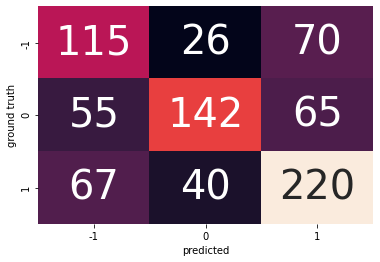

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
print(classification_report(test, test_preds))
sns.heatmap((confusion_matrix(test,test_preds)),annot=True,annot_kws={"size": 40},cbar=False,fmt = 'g',
            xticklabels=[-1,0,1],
            yticklabels=[-1,0,1])

plt.xlabel('predicted')
plt.ylabel('ground truth')
plt.show()

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
result[result['Tlabel'] != result['prediction']]

,Tweet text processed,Tlabel,prediction,score
1,. khanumarfa odd day : pic 1 even day : pic 2 ...,0.0,1.0,0.962070
2,so close to the absurdity called # oddeven. # ...,0.0,1.0,0.999778
11,look at the hoarding claiming # oddeven reduce...,0.0,1.0,1.000000
12,arvindkejriwal hello sirji... please provide u...,1.0,0.0,0.999990
14,surprisingly the traffic ws under super contro...,1.0,0.0,0.997915
15,and we have hoardings in delhi claiming # odde...,0.0,1.0,0.999998
19,arvindkejriwal weather may have cleared up lil...,1.0,0.0,1.000000
20,tmc member of parliament speaking while wearin...,0.0,1.0,1.000000
23,"awesome, so aqi back to 'very poor', well, # o...",1.0,0.0,1.000000
26,this is what we get after the huge success of ...,1.0,0.0,1.000000
